In [1]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.io import read_image

class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        """
        Custom dataset para cargar imágenes y anotaciones.
        :param images_dir: directorio con imágenes.
        :param labels_dir: directorio con archivos de anotaciones.
        :param transform: transformaciones de PyTorch para aplicar a las imágenes.
        """
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

        # Lista de nombres de archivos (sin extensión)
        self.image_files = [f.split('.')[0] for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Cargar imagen
        image_path = os.path.join(self.images_dir, self.image_files[idx] + '.jpg')
        image = Image.open(image_path).convert("RGB")

        # Cargar anotaciones
        label_path = os.path.join(self.labels_dir, self.image_files[idx] + '.txt')
        boxes = []
        labels = []
        with open(label_path, 'r') as file:
            for line in file:
                xmin, ymin, xmax, ymax, class_id = map(int, line.strip().split())
                boxes.append([xmin, ymin, xmax, ymax])

                if class_id == 7: # Balon
                    class_id = 2 # Clase 2 es balon
                else: # Jugadores, arbitros, porteros, extra
                    class_id = 1 # Clase 1 es jugador
                labels.append(class_id)

        # Convertir a tensores
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Crear un diccionario con la imagen y las anotaciones

        num_objs = len(labels)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = int(image_id)
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transform:
            image = self.transform(image)

        return image, target

# Ejemplo de uso
# dataset = CustomDataset(images_dir="path/to/images", labels_dir="path/to/labels")

In [22]:
# from torchvision import transforms

# def get_transform(train):
#     transforms_list = []
#     # Convertir la imagen PIL a un tensor PyTorch
#     transforms_list.append(transforms.ToTensor())
#     if train:
#         # Durante el entrenamiento, puedes añadir otras transformaciones aquí
#         pass
#     # Normalización con los mismos parámetros usados para el entrenamiento en ImageNet
#     transforms_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                                 std=[0.229, 0.224, 0.225]))
#     return transforms.Compose(transforms_list)

In [3]:
import torchvision.models.detection as detection
from torchvision.models import ResNet50_Weights

def get_model(num_classes):
    # Cargar un modelo preentrenado
    model = detection.fasterrcnn_resnet50_fpn(
        weights=detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1, 
        # num_classes = 3, 
        weights_backbone = ResNet50_Weights.DEFAULT,
        trainable_backbone_layers = 1,
    )

    model = detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Obtener el número de características de entrada del clasificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Reemplazar la cabeza del clasificador con una nueva
    model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

# Aquí, num_classes es 3 (2 clases + 1 para el fondo)
model = get_model(num_classes=3)

In [4]:
import torch.optim as optim

# Parámetros del optimizador
lr = 0.001
momentum = 0.9
weight_decay = 0.0005

# Optimizador
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [5]:
import torch
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split

In [6]:
# Supongamos que 'dataset' es tu CustomDataset ya creado anteriormente
dataset = CustomDataset(images_dir="../YOLO2/dataset/train/images/", labels_dir="./data/train/labels/",  transform=get_transform(train=True))

print(len(dataset))

42750


In [7]:
# # Divide los datos en entrenamiento y validación
# n_val = int(len(dataset) * 0.8)  # 50% para validación
# n_train = len(dataset) - n_val
# train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
# print(len(train_dataset))

In [8]:
# Calcular el 10% del tamaño total del dataset
subset_size = int(len(dataset) * 0.1)

# Calcular las longitudes de entrenamiento y validación del subconjunto
n_train_subset = int(subset_size * 0.5)
n_val_subset = subset_size - n_train_subset  # Esto garantiza que la suma sea igual al tamaño del subconjunto

# Obtener índices para el subconjunto (podría ser aleatorio o los primeros N índices)
indices = torch.randperm(len(dataset))[:subset_size]

# Dividir los índices del subconjunto en entrenamiento y validación
train_indices = indices[:n_train_subset]
val_indices = indices[n_train_subset:]

# Crear los subconjuntos de entrenamiento y validación
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)

print(len(train_subset), len(val_subset))

2137 2138


In [9]:
import utils

# Crea los DataLoader para entrenamiento y validación
train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True, collate_fn=utils.collate_fn)
val_loader = DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True, collate_fn=lambda x: tuple(zip(*x)))

In [10]:
# Configuración del modelo y del optimizador
model = get_model(num_classes=3)  # Asegúrate de que el modelo esté en modo entrenamiento
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [11]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,4,7'
print(os.environ['CUDA_VISIBLE_DEVICES'])


torch.cuda.is_available()
torch.cuda.device_count()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

from torch.nn import DataParallel

model.to(device)
model = DataParallel(model)  # Esto envolverá tu modelo para que se ejecute en paralelo en todas tus GPUs disponibles


2,4,7
cuda


In [12]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#testing-forward-method-optional

# For Training
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

print(type(targets))
print(len(targets))
print(targets[0])  # Imprime el primer elemento para entender su estructura
for target in targets:
    print("***Nuevo***")
    if isinstance(target, torch.Tensor):
        print(target.shape)
    elif isinstance(target, dict):
        # Si es un diccionario, imprime la forma de cada tensor en el diccionario
        for key, value in target.items():
            if isinstance(value, torch.Tensor):
                print(f"{key}: {value.shape}")

<class 'list'>
4
{'boxes': tensor([[ 933.,  595.,  950.,  611.],
        [1592.,  658., 1678.,  788.],
        [ 555.,  651.,  647.,  776.],
        [ 900.,  562.,  963.,  663.],
        [1541.,  438., 1584.,  514.],
        [ 717.,  561.,  794.,  661.],
        [ 110.,  637.,  172.,  762.],
        [ 620.,  557.,  669.,  672.],
        [1135.,  623., 1202.,  734.],
        [1433.,  673., 1517.,  788.],
        [ 590.,  516.,  642.,  611.],
        [1480.,  736., 1570.,  886.],
        [1310.,  679., 1386.,  814.],
        [ 935.,  624., 1042.,  735.],
        [ 136.,  684.,  214.,  805.],
        [ 664.,  550.,  716.,  672.],
        [1309.,  643., 1386.,  766.],
        [ 965.,  563., 1037.,  665.],
        [ 793.,  519.,  842.,  619.],
        [ 839.,  599.,  918.,  701.],
        [ 324.,  616.,  394.,  729.]]), 'labels': tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': 7570, 'area': tensor([  272., 11180., 11500.,  6363.,  3268.,  7700.,  7750., 

In [13]:
output = model(images, targets)  # Returns losses and detections
print(output)

{'loss_classifier': tensor([1.6753, 1.6985, 1.7502], device='cuda:0', grad_fn=<GatherBackward>), 'loss_box_reg': tensor([0.1982, 0.1055, 0.1402], device='cuda:0', grad_fn=<GatherBackward>), 'loss_objectness': tensor([0.2808, 0.2466, 0.4377], device='cuda:0', grad_fn=<GatherBackward>), 'loss_rpn_box_reg': tensor([0.1676, 0.1215, 0.3677], device='cuda:0', grad_fn=<GatherBackward>)}


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [14]:
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'boxes': tensor([[ 13.3570,  18.7214, 195.4452, 156.5921],
        [  0.0000,   7.3758, 269.2052, 236.7566],
        [  3.2603, 121.8126, 185.8034, 263.8538],
        ...,
        [145.7215,  71.4642, 148.5977,  74.6156],
        [154.6083,  76.6787, 157.4333,  79.9134],
        [149.1116,  72.2002, 151.7710,  75.0222]], device='cuda:0',
       grad_fn=<GatherBackward>), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [15]:
# Número de épocas
num_epochs = 1

In [16]:
# from torchvision.ops import box_iou

# def calculate_accuracy(predictions, targets, iou_threshold=0.5):
#     accuracy = []
#     for prediction, target in zip(predictions, targets):
#         # Obtén las bounding boxes y las etiquetas predichas con puntuaciones más altas que un umbral
#         pred_boxes = prediction['boxes'][prediction['scores'] > 0.8].cpu()
#         pred_labels = prediction['labels'][prediction['scores'] > 0.8].cpu()
#         true_boxes = target['boxes'].cpu()
#         true_labels = target['labels'].cpu()

#         # Calcula la IoU para cada predicción con cada verdadera bounding box
#         ious = box_iou(pred_boxes, true_boxes)  # Necesitas implementar esta función o usar una de torchvision

#         # Determina si las predicciones son verdaderos positivos o falsos positivos
#         tp = 0
#         for i, pred_label in enumerate(pred_labels):
#             # Encuentra el mejor emparejamiento verdadero con IoU más alto que el umbral
#             matched_iou, best_match_idx = ious[i].max(0)
#             if matched_iou > iou_threshold and pred_label == true_labels[best_match_idx]:
#                 tp += 1

#         # Calcula la precisión para esta imagen
#         if len(pred_labels) > 0:
#             accuracy.append(tp / len(pred_labels))
#         else:
#             accuracy.append(0)

#     # Devuelve la precisión promedio sobre todas las imágenes
#     return sum(accuracy) / len(accuracy)

In [17]:
print(len(train_subset)/4)

534.25


In [34]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    # transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ConvertImageDtype(torch.float)) # Cambia el tipo de datos a float
    transforms.append(T.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])) # Escala los valores
    # transforms.append(T.ToPureTensor())
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [19]:
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [20]:
# Traing given by Pytorch
# train_loader # val_loader
from engine import train_one_epoch, evaluate

# move model to the right device
# Aquí, num_classes es 3 (2 clases + 1 para el fondo)
model = get_model(num_classes=3)
model.to(device)
model = DataParallel(model)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_loader, device=device )

print("That's it!")
torch.save(model.state_dict(), "FasterRCNN_pytorch_training.pth")

Epoch: [0]  [  0/535]  eta: 0:14:45  lr: 0.000014  loss: 1.6547 (1.6547)  loss_classifier: 0.9956 (0.9956)  loss_box_reg: 0.0755 (0.0755)  loss_objectness: 0.4438 (0.4438)  loss_rpn_box_reg: 0.1398 (0.1398)  time: 1.6549  data: 0.7158  max mem: 9086
Epoch: [0]  [ 10/535]  eta: 0:06:25  lr: 0.000108  loss: 1.5920 (1.4430)  loss_classifier: 0.7599 (0.7430)  loss_box_reg: 0.1271 (0.1517)  loss_objectness: 0.4018 (0.3883)  loss_rpn_box_reg: 0.1658 (0.1600)  time: 0.7339  data: 0.0658  max mem: 9440
Epoch: [0]  [ 20/535]  eta: 0:05:54  lr: 0.000201  loss: 1.1865 (1.2834)  loss_classifier: 0.4388 (0.5789)  loss_box_reg: 0.2358 (0.2219)  loss_objectness: 0.2978 (0.3203)  loss_rpn_box_reg: 0.1607 (0.1624)  time: 0.6399  data: 0.0006  max mem: 9440
Epoch: [0]  [ 30/535]  eta: 0:05:41  lr: 0.000295  loss: 0.9950 (1.1529)  loss_classifier: 0.3678 (0.4933)  loss_box_reg: 0.2965 (0.2450)  loss_objectness: 0.1910 (0.2619)  loss_rpn_box_reg: 0.1315 (0.1527)  time: 0.6445  data: 0.0004  max mem: 9440


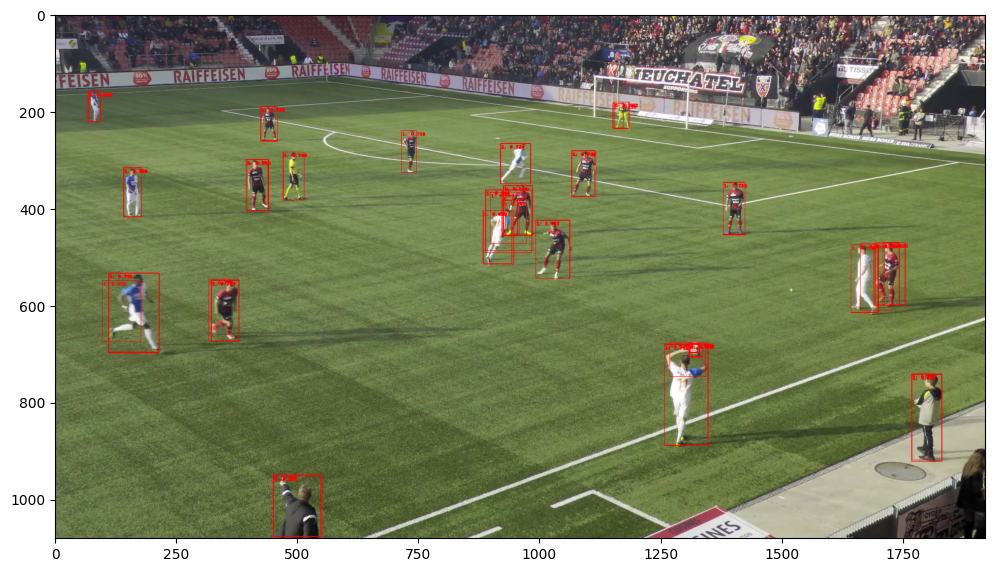

In [36]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("../YOLO2/dataset/train/images/000151000750.jpg")
# image_path = "../challenge/SNMOT-021/img1/000675.jpg"
# image_path = "../YOLO2/dataset/train/images/000151000750.jpg"
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))


In [ ]:
# from torch.cuda.amp import GradScaler, autocast

# scaler = GradScaler()

# for epoch in range(num_epochs):
#     # Entrenamiento
#     model.train()
#     total_loss = 0
#     epoch_loss_sum = 0

#     numImg = 0
#     for images, targets in train_loader:
#         numImg += 1
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
#         # with autocast():
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         epoch_loss_sum += losses.cpu().detach().numpy() # Added
#         loss = losses.mean()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
        
#         # scaler.scale(loss).backward()
#         # scaler.unscale_(optimizer)
#         # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
#         # scaler.step(optimizer)
#         # scaler.update()

#         if numImg % 500 == 0:
#             print(str(numImg) + " batches")

#     epoch_loss_mean = total_loss / len(train_loader)
    
#     print(print(f"Epoch {epoch} - TRAINED"))
#     # # Validación
#     # model.eval()
#     # accuracy_scores = []
#     # with torch.no_grad():
#     #     for images, targets in val_loader:
#     #         images = list(image.to(device) for image in images)
#     #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#     #         predictions = model(images)

#     #         for prediction, target in zip(predictions, targets):
#     #             out_bbox = predictions["boxes"]
#     #             out_scores = predictions["scores"]
#     #             keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)


#             # Aquí deberías calcular las métricas de validación como la precisión, el mAP, etc.
#             # Calcula la precisión para el lote actual y guárdala
#             # batch_accuracy = calculate_accuracy(predictions, targets)
#             # accuracy_scores.append(batch_accuracy)
    
#     # Calcula la precisión promedio para todos los lotes
#     # mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
#     # print(f"Validation Accuracy: {mean_accuracy:.4f}")

#     print(f"Epoch {epoch}: LossSum: {epoch_loss_sum} | LossMean {epoch_loss_mean}")

    

# # Guarda el modelo después de entrenar
# torch.save(model.state_dict(), "newModelFasterRCNN.pth")

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# COCO_CLASSES = [    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',     'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',     'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',     'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',     'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',     'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',     'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',     'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',     'hair drier', 'toothbrush']

COCO_CLASSES = [    'person', 'ball']

def plot_predictions(img_tensor, prediction):
    

    # Convertir el tensor de la imagen a numpy y desnormalizar
    img_np = img_tensor.squeeze().permute(1, 2, 0).numpy()
    
    # Crear una figura y ejes
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Mostrar la imagen
    ax.imshow(img_np)
    
    # Extraer los bounding boxes y las etiquetas
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores']
    keep = torchvision.ops.nms(boxes, scores, 0.45)
    # keep = keep.cpu().numpy()
    print(keep)

    boxes = boxes.cpu().numpy()
    scores = scores#.cpu().numpy()

    boxesKeep = [boxes[i] for i in keep]
    labelsKeep = [labels[i] for i in keep]
    scoresKeep = [scores[i] for i in keep]

    scores = scores.cpu().numpy()
    # Dibujar todos los bounding boxes
    for box, label, score in zip(boxesKeep, labelsKeep, scoresKeep):
        class_name = COCO_CLASSES[label - 1]  # -1 porque COCO comienza desde 1
        if score > 0.1:  # Solo mostramos las detecciones con una confianza superior al 50%
            x, y, xmax, ymax = box
            rect = plt.Rectangle((x, y), xmax-x, ymax-y, fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x, y, f"Class: {class_name}, Score: {score:.2f}", color='white', backgroundcolor='red', fontsize=8, bbox=dict(facecolor='red', alpha=0.5, edgecolor='red', boxstyle='round,pad=0.1'))


            # ax.text(x, y, f"{class_name}: {score:.2f}", ...)
    plt.axis('off')
    plt.show()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 24, 25], device='cuda:0')


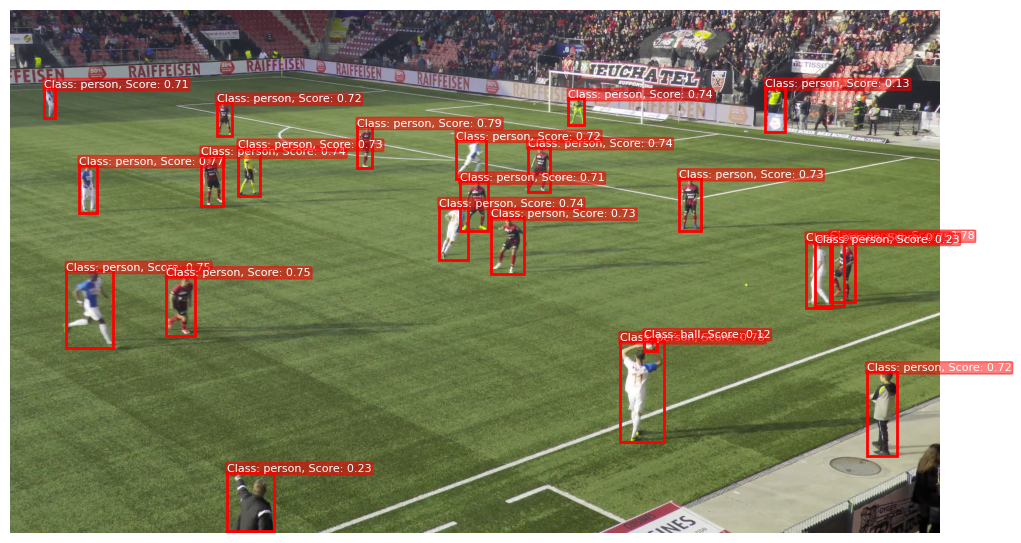

In [43]:
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import torchvision

# # Cargar el modelo preentrenado
# model = fasterrcnn_resnet50_fpn(pretrained=True)

# Poner el modelo en modo de evaluación
model.eval()

# Cargar y preprocesar la imagen
# image_path = "soccer.jpg"
# image_path = "../challenge/SNMOT-021/img1/000675.jpg"
image_path = "../YOLO2/dataset/train/images/000151000750.jpg"
# image = Image.open(image_path).convert("RGB")
# image_tensor = F.to_tensor(image).unsqueeze(0)
image = T.ToTensor()(Image.open(image_path)).unsqueeze(0)

# Obtener predicciones
with torch.no_grad():
    prediction = model(image)

# Visualizar las predicciones
plot_predictions(image.squeeze(), prediction)